In [212]:
from os import path
from itertools import cycle
import json
import string
import pickle
import numpy as np
from scipy import special
import pandas as pd
import pystan
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

sns.set(context="notebook", font_scale=1.5, style="ticks", color_codes=True, palette="deep")

In [2]:
def load_model(filename):
    with open(filename) as f:
        model_code = f.read()
    pklname = path.splitext(filename)[0] + ".pkl"
    if path.isfile(pklname):
        sm = pickle.load(open(pklname, "rb"))
        if sm.model_code == model_code:
            return sm
    sm = pystan.StanModel(model_code=model_code)
    pickle.dump(sm, open(pklname, "wb"))
    return sm

def logit(y):
    return special.logit(y)

def logistic(x):
    return special.expit(x)

## Generate mock data

In [109]:
sm = load_model("mmglm_predict.stan")

In [209]:
exec(open("predict_inputs.py").read())
fit = sm.sampling(data=inputs, chains=1, warmup=500, iter=501)
df = fit.to_dataframe()
df.head()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,chain,draw,warmup,"z_u[1,1]","z_u[2,1]","z_u[3,1]","z_u[4,1]","z_u[5,1]","z_u[6,1]","z_u[7,1]",...,T_dp[358],T_dp[359],T_dp[360],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,0.718909,0.692772,0.271301,0.859036,-0.472028,-0.464045,0.685388,...,1.824848,8.464852,0.001168,-890.473949,0.995701,0.213246,4,15,0,1762.374146


In [215]:
colors

{0: 'C0', 1: 'C1', 2: 'C2'}

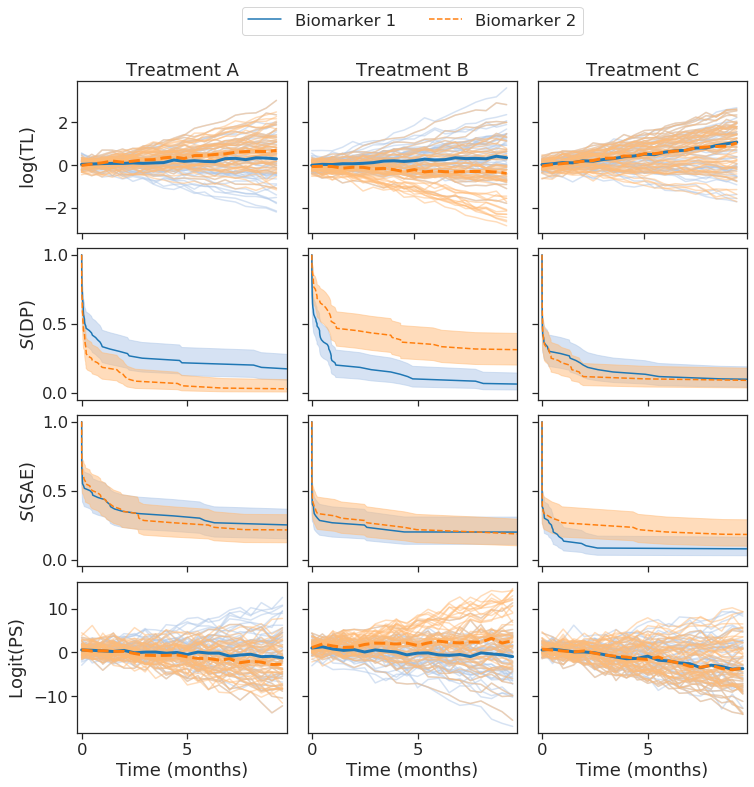

In [221]:
N_bm = inputs["N_bm"]
N_tx = inputs["N_tx"]
N_pt = inputs["N_pt"]
tmin = 0
tmax = 10
dt = 0.5
t = np.arange(tmin, tmax, dt)

x_bm = np.array(inputs["bm_inputs"])
x_tx = np.array(inputs["tx_indicators"])

N_outcomes = 4

fig, axes = plt.subplots(nrows=N_outcomes, ncols=N_tx, sharex="col", sharey="row", 
                         figsize=(4 * N_tx, 3 * N_outcomes),
                         gridspec_kw=dict(wspace=0.1, hspace=0.1))

y_tl_all = np.zeros((N_pt, N_t))
for pt in range(N_pt):
    y_tl_all[pt] = np.array([df.loc[0, f"y_tl[{i + N_t * pt}]"] for i in range(1, 1 + N_t)])

y_ps_all = np.zeros((N_pt, N_t))
for pt in range(N_pt):
    y_ps_all[pt] = np.array([df.loc[0, f"y_ps[{i + N_t * pt}]"] for i in range(1, 1 + N_t)])

sns.set_palette("tab20")
dark_colors = {bm: f"C{2 * bm}" for bm in range(N_bm)}
light_colors = {bm: f"C{2 * bm + 1}" for bm in range(N_bm)}
lines = {0: "-", 1: "--"}

for bm in range(N_bm):
    for tx in range(N_tx):
        patients = np.arange(N_pt)[(x_bm[:, bm] != 0) & (x_tx[:, tx] != 0)]
        # individual patient trajectories
        for pt in patients:
            axes[0, tx].plot(t, np.log(y_tl_all[pt]), 
                               color=light_colors[bm], alpha=0.5, zorder=1)
            axes[3, tx].plot(t, logit(y_ps_all[pt]), 
                             color=light_colors[bm], alpha=0.5, zorder=1)
        # median trajectories
        axes[0, tx].plot(t, np.median(np.log(y_tl_all[patients]), axis=0), 
                           color=dark_colors[bm], ls=lines[bm], lw=3, zorder=3)
        axes[3, tx].plot(t, np.median(logit(y_ps_all[patients]), axis=0), 
                           color=dark_colors[bm], ls=lines[bm], lw=3, zorder=3)
        
        # KM DP survival estimates
        T = np.array([df.loc[0, f"T_dp[{1 + pt}]"] for pt in patients])
        fit = kmf.fit(T)
        S = fit.survival_function_
        low, high = fit.confidence_interval_survival_function_.values.T
        timeline = fit.timeline
        axes[1, tx].plot(timeline, S,
                         color=dark_colors[bm], ls=lines[bm], zorder=3)
        axes[1, tx].fill_between(timeline, low, high,
                                 color=light_colors[bm], alpha=0.5, zorder=1)

        # KM SAE survival estimates
        T = np.array([df.loc[0, f"T_sae[{1 + pt}]"] for pt in patients])
        fit = kmf.fit(T)
        S = fit.survival_function_
        low, high = fit.confidence_interval_survival_function_.values.T
        timeline = fit.timeline
        axes[2, tx].plot(timeline, S,
                         color=dark_colors[bm], ls=lines[bm], zorder=3)
        axes[2, tx].fill_between(timeline, low, high,
                                 color=light_colors[bm], alpha=0.5, zorder=1)

tx_labels = [f"Treatment {string.ascii_uppercase[tx]}" for tx in range(N_tx)]
for tx in range(N_tx):
    axes[N_outcomes - 1, tx].set_xlabel("Time (months)")
    axes[0, tx].set_xlim(t.min() - 0.2, t.max() + 0.2)
    axes[0, tx].set_xticks(ticks=[0, 5, 10])
    axes[0, tx].set_title(tx_labels[tx])
axes[0, 0].set_ylabel(r"$\log(\mathrm{TL})$")
axes[1, 0].set_ylabel(r"$S(\mathrm{DP})$")
axes[2, 0].set_ylabel(r"$S(\mathrm{SAE})$")
axes[3, 0].set_ylabel(r"$\mathrm{Logit}(\mathrm{PS})$");

handles = [mpl.lines.Line2D([], [], linestyle=lines[bm], color=dark_colors[bm]) for bm in range(N_bm)]
axes[0, 1].legend(labels=["Biomarker 1", "Biomarker 2"],
                  handles=handles,
                  loc="lower center", 
                  bbox_to_anchor=(0.5, 1.25),
                  ncol=2)
plt.savefig("figs/mock_responses.pdf", bbox_inches="tight")